In [106]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

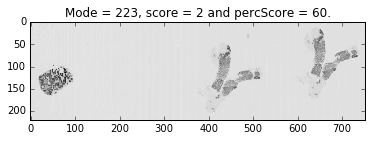

In [2]:
groundTruth = pd.read_csv("data/groundTruth.csv")
class her2Image():
    def __init__(self,caseNumber):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
        self.level = self.nLevels - 3
        self.lowResDims = self.her2.level_dimensions[self.level] #3 is arbitrary but works
        self.lowResRGB = np.asarray(self.her2.read_region((0,0),self.level,(self.lowResDims[0],self.lowResDims[1]))) 
        self.lowRes = cv2.cvtColor(self.lowResRGB, cv2.COLOR_RGB2GRAY) # Grayscale
        self.lowResArea = reduce(mul,self.lowResDims) # Area of image
        self.mode = mstats.mode(self.lowRes,axis=None)[0]
        
        # Thresholded image
        img = cv2.GaussianBlur(self.lowRes,(47,47),0)
        ret,self.thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-4,255,1)
        
    def show(self):
        plt.imshow(self.lowRes,cm.gray)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        
            
    def upScale(self,level,show=0): 
        self.highResLevel = level
        self.highResSF = np.power(2,self.level-self.highResLevel)
        self.highlevelDims = self.her2.level_dimensions[level]
        self.highRes = np.asarray(self.her2.read_region((0,0),self.highResLevel,(self.highlevelDims[0],self.highlevelDims[1])))

            

for i in groundTruth.CaseNo.values[1:2]:
    eg = her2Image(i)
    eg.show()

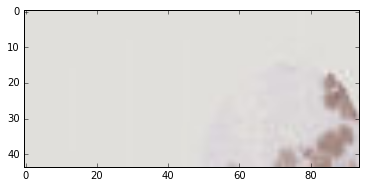

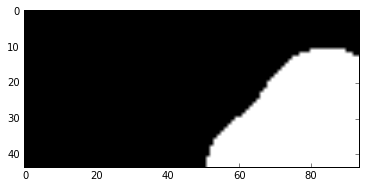

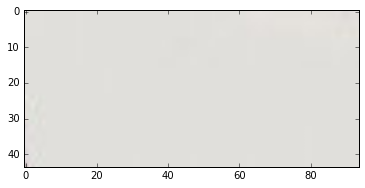

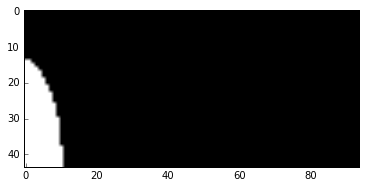

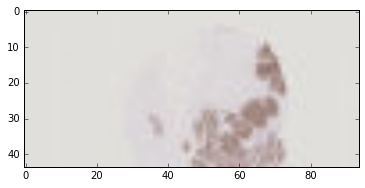

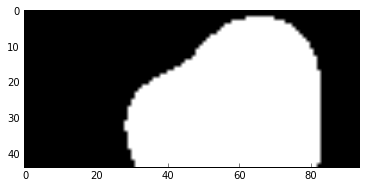

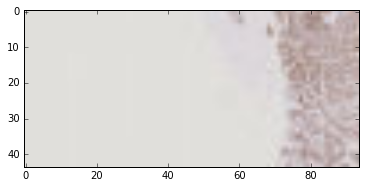

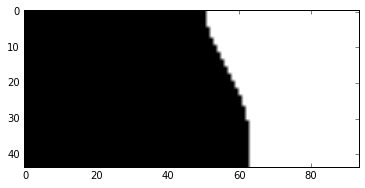

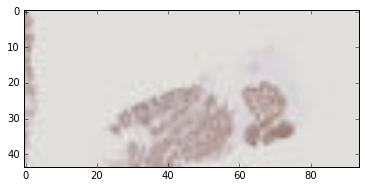

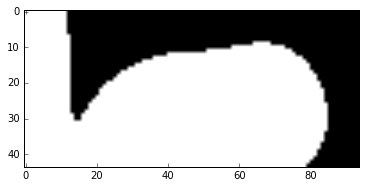

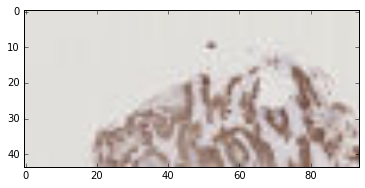

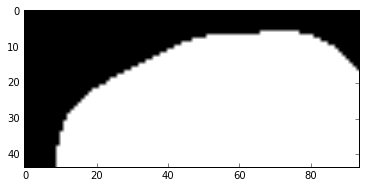

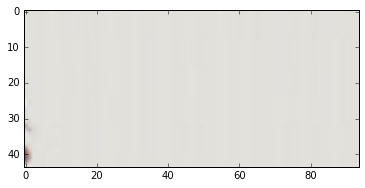

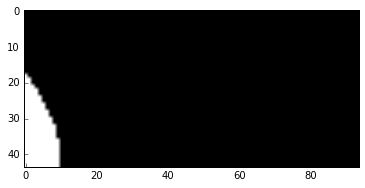

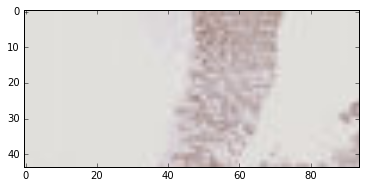

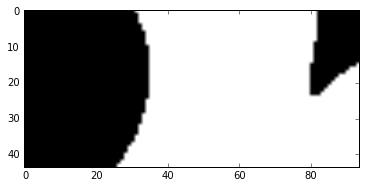

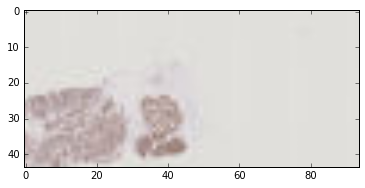

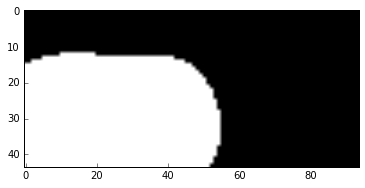

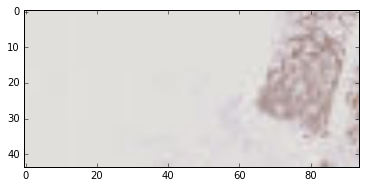

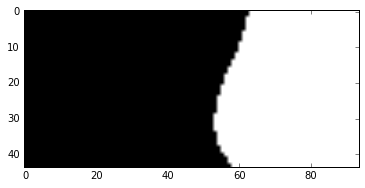

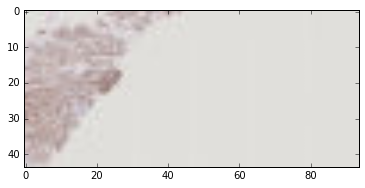

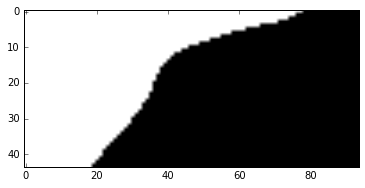

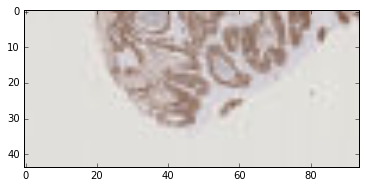

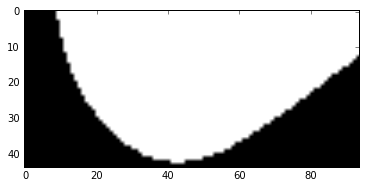

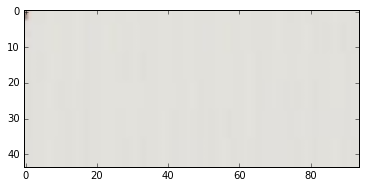

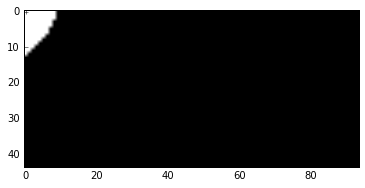

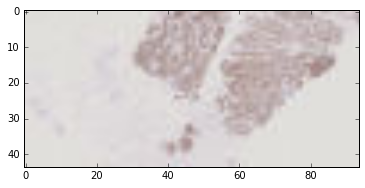

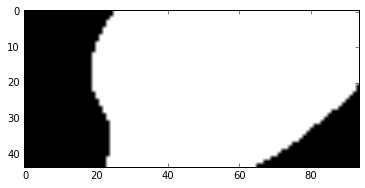

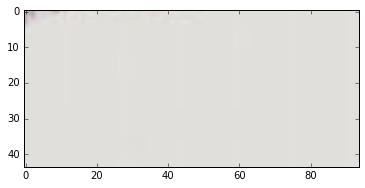

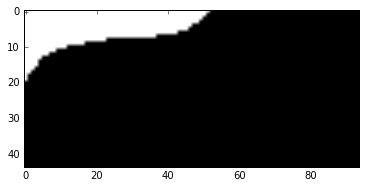

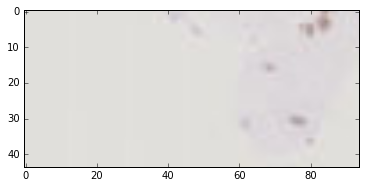

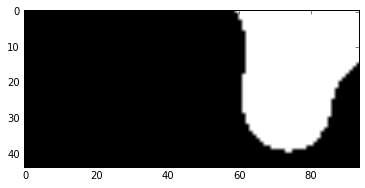

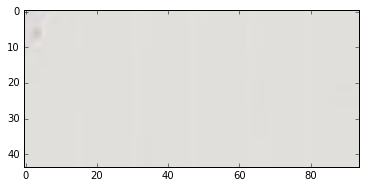

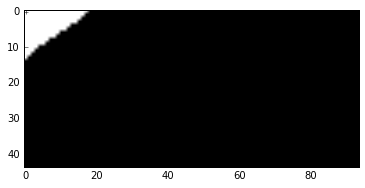

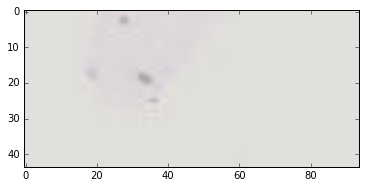

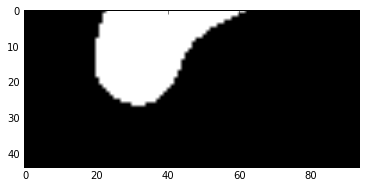

In [14]:
def factors(n,k):    
    facs = reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))
    return sorted(facs)[-k]

def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

nrows,ncols = map(lambda dim: factors(dim,4),eg.lowRes.shape)

coordsX,coordsY = np.indices((eg.lowRes.shape[0],eg.lowRes.shape[1]))
blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
blocksThresh = blockshaped(eg.thresh,nrows,ncols)
blocksLowRes = blockshaped(eg.lowRes,nrows,ncols)

relaventCoords = []
featureBlocks = np.where(np.any(blocksThresh==255,axis=(1,2)))[0]
for block in featureBlocks:
    relaventCoords.append((blocksX[block],blocksY[block]))
    plt.imshow(eg.lowResRGB[(blocksX[block],blocksY[block])],cmap=cm.gray)
    plt.show()
    plt.imshow(blocksThresh[block],cmap=cm.gray)
    plt.show()

In [93]:
def getBoxCoords(blocksPair,level,upscaleLevel):
    x = blocksPair[1]
    x1 = x[0][0]
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0]
    y2 = y[-1][0]
    print("X",x1,x2)
    print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    #return (upscaledX),(upscaledY)
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size


('X', 658, 751)
('Y', 44, 87)
((168448, 11264), (1488, 688))
(12032, 3520)


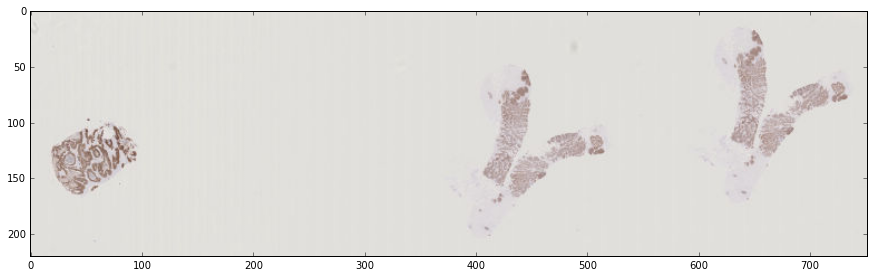

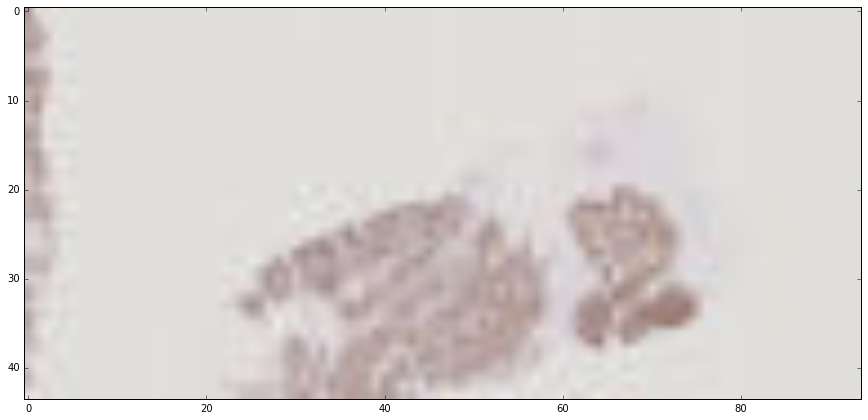

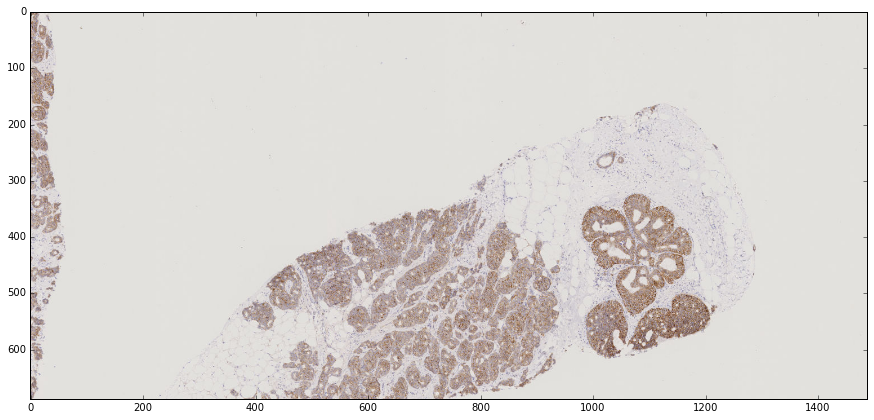

In [108]:
i = 4
upscaleLevel= 4

location, size = getBoxCoords(relaventCoords[i],eg.level,upscaleLevel)
print(location,size)
print(eg.her2.level_dimensions[upscaleLevel])

plt.imshow(eg.lowResRGB)
plt.show()
plt.imshow(eg.lowResRGB[relaventCoords[i]])
plt.show()

plt.imshow(eg.her2.read_region((location[0],location[1]),upscaleLevel,
                               (size[0],size[1])))
plt.show()